In [1]:
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from numpy.linalg import norm
from scipy.spatial.distance import cdist

In [ ]:
def make_video(opt, run_time):
    fig_path = opt["save_path"]
    fig_list = sorted([os.path.join(fig_path, f) for f in os.listdir(fig_path) if f.endswith(('.png'))])
    imgs = [Image.open(i) for i in fig_list]
    imgs[0].save(os.path.join(fig_path, f"output_{opt['fold_name']}_{run_time}.gif"),
                save_all=True,
                append_images=imgs[1:],
                duration=500,
                loop=0)
    
def save_procedure(iterate, C, cols, rows, opt):
    output_path = opt["save_path"]
    color_map = opt["color_map"]
    fig = np.zeros((len(C), 3), np.uint8)
    for i in range(len(C)):
        fig[i] = color_map[C[i]]

    fig = fig.reshape(cols, rows, 3)
    plt.imsave(os.path.join(output_path, f'{iterate}.png'), fig)

def plot_eigenspace(H, C, opt):
    output_path = opt["save_path"]
    color_map = np.array(opt["color_map"])
    color_map = color_map / 255
    if opt["num_clusters"] == 2:
        for i in range(2):
            x = H[np.where(C==i)[0], 0]
            y = H[np.where(C==i)[0], 1]
            plt.scatter(x, y, c=[color_map[i]], s=0.5)
        plt.savefig(os.path.join(output_path, f"output_{opt['fold_name']}_eigen.png"))
    elif opt["num_clusters"] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i in range(3):
            x = H[np.where(C==i)[0], 0]
            y = H[np.where(C==i)[0], 1]
            z = H[np.where(C==i)[0], 2]
            ax.scatter(x, y, z, c=[color_map[i]], s=0.5)
        plt.savefig(os.path.join(output_path, f"output_{opt['fold_name']}_eigen.png"))


In [3]:
def spatial_color_RBFkernel(X, cols, rows, opt):
    gamma_s, gamma_c = opt["gamma_s"], opt["gamma_c"]
    coords = np.array([[i, j] for i in range(rows) for j in range(cols)])

    # Compute squared distances for spatial and color features
    spatial_dists = cdist(coords, coords, metric='sqeuclidean')  # 10000x10000
    color_dists = cdist(X, X, metric='sqeuclidean')
    # Compute the kernel matrix
    kernel_matrix = np.exp(-gamma_s * spatial_dists) * np.exp(-gamma_c * color_dists)
    return kernel_matrix

def laplacian(W, opt):
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    if opt["cut"] == 'ratio':
        return L
    elif opt["cut"] == 'normalized':
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D))) # D^-1/2
        L_sym = D_inv_sqrt @ L @ D_inv_sqrt # L_sym = D^-1/2 L D^-1/2
        return L_sym, D_inv_sqrt

def embedding(L, opt):
    K = opt["num_clusters"]
    npy_path = opt["save_path"]
    try:
        eigenvalues = np.load(os.path.join(npy_path, "eigenvalues.npy"))
        eigenvectors = np.load(os.path.join(npy_path, "eigenvectors.npy"))
    except:
        # Solve eigen problem
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        np.save(os.path.join(npy_path, "eigenvalues.npy"), eigenvalues)
        np.save(os.path.join(npy_path, "eigenvectors.npy"), eigenvectors)
        
    idx = np.argsort(eigenvalues)
    eigenvectors = eigenvectors[:, idx]

    # Select the first k eigenvectors
    embedding = eigenvectors[:, 1:K+1].real
    return embedding

In [4]:
""" Initialize  Mean """
def init_means(data, opt):
    METHOD = opt["init_method"]
    K = opt["num_clusters"]
    N = len(data)

    if METHOD == "random":
        # Randomly select K unique indices as initial cluster centers
        initial_indices = random.sample(range(N), K)
        initial_centers = data[initial_indices]
    if METHOD == "kmeans++":
        centers_indices = [random.randint(0, N - 1)]  # Random index as the first center
        initial_centers = [data[centers_indices[0]]]
        
        # Select remaining K-1 centers
        for _ in range(1, K):
            # Compute squared distances to the nearest selected center
            dist = np.min(cdist(data, np.array(initial_centers), metric='euclidean'), axis=1)

            # Normalize distances to get probabilities
            prob = dist / np.sum(dist)

            # Sample a new center index based on the probability
            new_center = np.random.choice(N, p=prob)
            centers_indices.append(new_center)
            initial_centers.append(data[new_center])
    
    # Compute distances from all data points to the initial centers
    distances = cdist(data, initial_centers, metric='euclidean')
    # Assign each point to the closest cluster
    initial_assignments = np.argmin(distances, axis=1)
    return np.array(initial_centers), np.array(initial_assignments)

""" Clustering """
def kmeans(H, init_centers, init_clusters, cols, rows, opt):
    max_iter = 100
    iterate = 1
    K = opt["num_clusters"]
    
    centers = init_centers.copy()
    C = init_clusters.copy()
    save_procedure(0, C, cols, rows, opt)
    
    prev_C = np.zeros_like(C)
    while(iterate < max_iter):
        print('iter ', iterate)
        for k in range(K):
            idx = np.where(C==k)[0] # Get indices of points in cluster k
            if len(idx) == 0:
                continue
            # Compute new centers
            centers[k] = np.mean(H[idx], axis=0)
        # Compute distances to each centers
        dist = cdist(H, centers, metric='euclidean')
        # Assign clusters
        C = np.argmin(dist, axis=1)
        if(norm(C - prev_C) < 1e-3):break # Check convergence
        save_procedure(iterate, C, cols, rows, opt)
        prev_C = C.copy()
        iterate += 1
        
    return C

In [ ]:
def main(opt):
    # Load image and reshape its size into (rows * cols, 3)
    img = cv2.imread(opt["img_dir"])
    rows, cols, _ = img.shape # 100x100x3
    num_pixel = rows * cols # 10000
    data = img.reshape(num_pixel, 3)

    # Compute kernel
    kernel_mat = spatial_color_RBFkernel(data, cols, rows, opt)
    
    if opt["cut"] == 'normalized':
        L_sym, D_inv_sqrt = laplacian(kernel_mat, opt)
        H = embedding(L_sym, opt)
        H = D_inv_sqrt @ H 
        init_centers, init_clusters = init_means(H, opt)
    elif opt["cut"] == 'ratio':
        L = laplacian(kernel_mat, opt)
        H = embedding(L, opt)
        init_centers, init_clusters = init_means(H, opt)

    star_time = time.time()
    C = kmeans(H, init_centers, init_clusters, cols, rows, opt)
    end_time = time.time()
    run_time = end_time - star_time
    make_video(opt, run_time)

    plot_eigenspace(H, C, opt)
    

iter  1
iter  2
iter  3


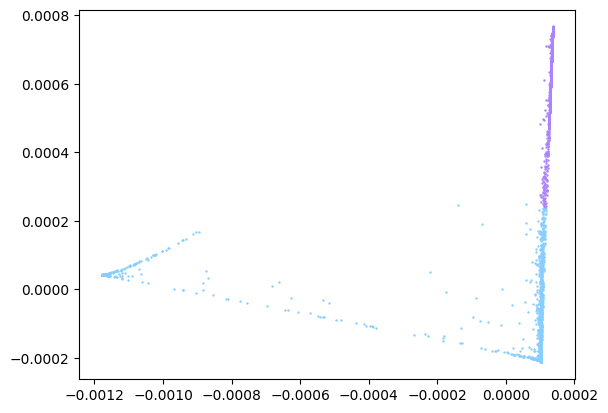

In [6]:
if __name__ == "__main__":
    opt = {
            "img_dir"      : "image1.png",
            "output_dir"   : "result",
            "init_method"  : "kmeans++", # random, kmeans++
            "cut"          : "normalized", # ratio, normalized
            "num_clusters" : 2,
            "gamma_s"      : 1e-4,
            "gamma_c"      : 1e-3,
            "color_map"    : [[135,206,255], [171,130,255], [255,130,171], [102,205,170], [255,236,139]]
        }
    img_name = os.path.split(opt["img_dir"])[-1].split('.')[0]
    opt["fold_name"] = f"spectral_kmean-{opt['cut']}-{opt['init_method']}-{opt['num_clusters']}-{opt['gamma_s']:.0e}-{opt['gamma_c']:.0e}"
    opt["save_path"] = os.path.join(opt["output_dir"], opt["fold_name"], img_name)
    os.makedirs(opt["save_path"], exist_ok=True)
    
    main(opt)
    
